# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
from lakemodel_function import lake_problem
from ema_workbench import Model, RealParameter, ScalarOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import Policy
from ema_workbench.analysis import feature_scoring

from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework import get_SALib_problem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


mpl.rcParams['lines.markersize'] = 3
plt.style.use('seaborn-white')

In [2]:
# number of levers in the lake_model
n_levers = 100

model = Model('LakeProblem', function=lake_problem)

# specify uncertainties
model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

# specify levers
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(n_levers)]

# specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [3]:
# specify the policies
policies = [Policy("0", **{l.name:0 for l in model.levers}),
          Policy("0.05", **{l.name:0.05 for l in model.levers}),
          Policy("0.1", **{l.name:0.1 for l in model.levers})]

In [4]:
# run experiments 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100, policies=policies , uncertainty_sampling='sobol')

experiments, outcomes = results

[MainProcess/INFO] pool started
C:\Users\Willy\Anaconda3\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 1200 scenarios * 3 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Given the performed experiments, we now perform a Sobol sensitivity analysis and analyse differences observed between the different policies. 

In [5]:
# for every policy, get the outcomes and analyse with sobol
policy_names = experiments.policy.unique().tolist()

problem = get_SALib_problem(model.uncertainties)

n_policies = len(policies)
n_experiments = len(experiments)
n_exp_pol = n_experiments/n_policies

sa_results = {}

for i in range(1,len(policies)+1):
    result = outcomes['reliability'][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
    
    sa = sobol.analyze(problem, result,
                   calc_second_order=True, print_to_console=False)
    sa_results[policy_names[i-1]] = sa

Policy 0


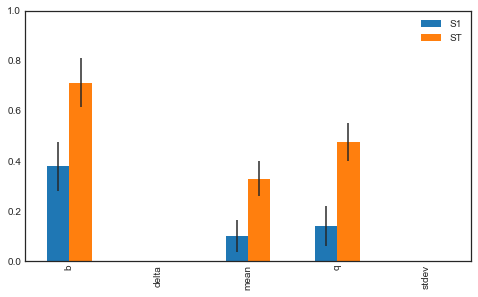

Policy 0.05


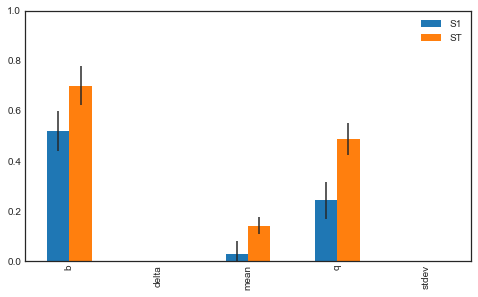

Policy 0.1


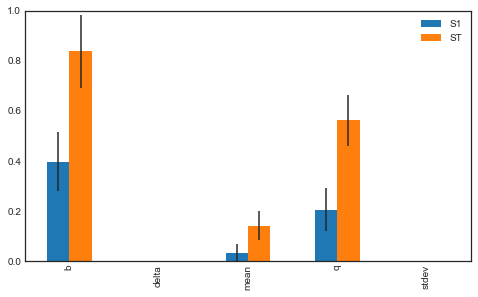

In [16]:
#Plot the SOBOL indices
for policy in policy_names:
    print('Policy '+policy)
    scores_filtered = {k:sa_results[policy][k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    #sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    ax.set_ylim([0,1])
    plt.show()

We can appreciate changes in the results for the different policies. In terms of relating the values to the different policies, one could argue that the policy '0' might be different given that a value of 0 might cancel out terms of equations. However, we still see a considerable difference between policies '0.05' and '0.1'. This could be explained becasue we have N = 1200 for each policy, while SOBOL requires >1000(k+2) where k is the number of uncertainties. This means we won't have a strong degree of stability for the SOBOL indices. 

To increase the number of runs while reducing computational power, we can rerun the experiment by chosing which uncertainties are relevant or not. In this case, we can see that the SOBOL indeces for delta and stdev are 0 in all cases so we could rerun the whole thing without taking them into account. However, we perform more experiments with all the uncertain parameters to double check.

In [7]:
# run experiments 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=600, policies=policies , uncertainty_sampling='sobol')

experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 7200 scenarios * 3 policies * 1 model(s) = 21600 experiments
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 4320 cases completed
[MainProcess/INFO] 6480 cases completed
[MainProcess/INFO] 8640 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12960 cases completed
[MainProcess/INFO] 15120 cases completed
[MainProcess/INFO] 17280 cases completed
[MainProcess/INFO] 19440 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
# for every policy, get the outcomes and analyse with sobol
policy_names = experiments.policy.unique().tolist()

problem = get_SALib_problem(model.uncertainties)

n_policies = len(policies)
n_experiments = len(experiments)
n_exp_pol = n_experiments/n_policies

sa_results = {}

for i in range(1,len(policies)+1):
    result = outcomes['reliability'][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
    
    sa = sobol.analyze(problem, result,
                   calc_second_order=True, print_to_console=False)
    sa_results[policy_names[i-1]] = sa

Policy 0


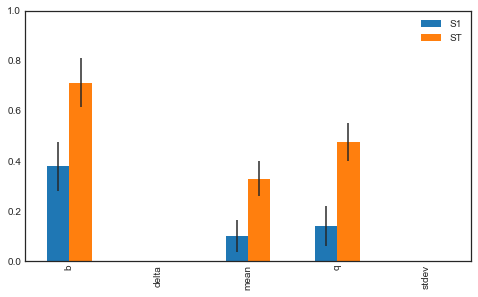

Policy 0.05


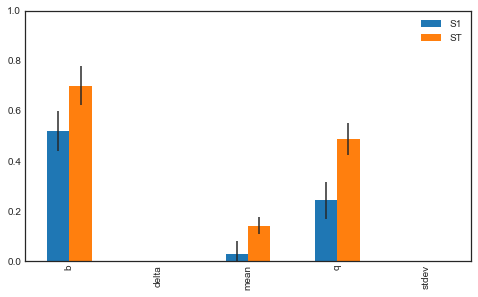

Policy 0.1


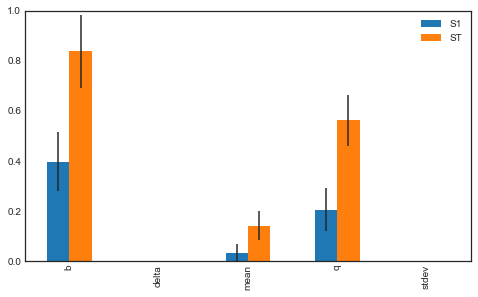

In [17]:
#Plot the SOBOL indices
for policy in policy_names:
    print('Policy '+policy)
    scores_filtered = {k:sa_results[policy][k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    #sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    ax.set_ylim([0,1])
    plt.show()

We can see how the variance of the values for the indices is now smaller, this highlights the  importance of increasing the number of experiments to obtain reliable results.

Again, we observe that the value of the indices changes depending on the policy. After analyzing the functions in the lake_model, we have not been able to properly understand this behavior. The levers are an independent term in X, so they should not affect the interaction between the uncertainties. However, when calculating the reliability, the value also depends on Pcrit. Still, given that the relation is an inequality, we have not been able to properly understand how the values of the indices are lower for the policy '0', increase in '0.05' and decrease again in '0.1' given that they should proportionately increase the value in X and thus follow a trend when applying the inequality.





2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [10]:
# dropping irrelevant columns for feature selection per policy
experiments_cleaned = experiments
experiments_cleaned.drop(['policy', 'model'], axis=1)
experiments_cleaned.drop(columns=[f"l{i}" for i in range(n_levers)], inplace=True)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


Policy: 0


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


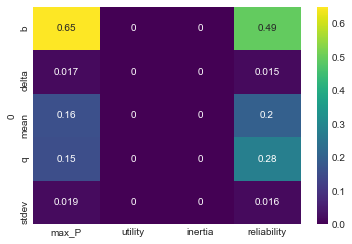

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


Policy: 0.05


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


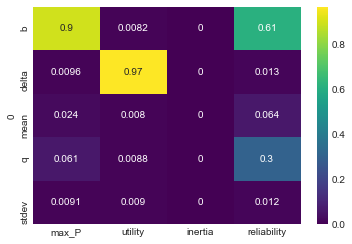

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


Policy: 0.1


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


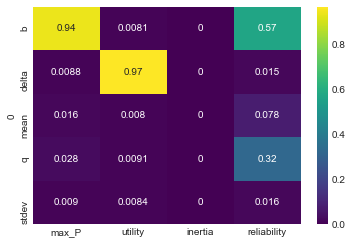

In [11]:
# perform feature selection per policy
outcomes_names = ['max_P','utility','inertia','reliability']
fs_results = {}

for i in range(1, len(policies)+1):
    for outcome in outcomes_names:
        result = outcomes[outcome][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]

        fs_results[outcome] = result
    
    print('Policy: %s' % policy_names[i-1])
    scores = feature_scoring.get_feature_scores_all(experiments_cleaned[int(n_exp_pol*(i-1)): int(n_exp_pol*i)],
                                                   fs_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

# Observations

Across all policies we observe that the input variable 'b' influences the max_p and reliability outcome with moderate to strong effect. Especially its effect on max_p increases when the policy levers are non-zero. Additionally, the input variable delta starts to have a strong effect on the utility outcome in the non-zero policies. This makes sense as, as there is no utility for the policymakers when the pollution is 0.